In [2]:
import numpy as np
import pandas as pd
import scipy as sc
import itertools

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
import matplotlib.pyplot as plt

%matplotlib inline

## One sample

### Data: laboratory mice and mirrors

16 laboratory mice were placed in two-room cages with a mirror in one of the rooms. To establish whether mice have any preferences for mirrors, a proportion of time spent in each of he rooms was measured for each mouse. 

Sherwin, C.M. (2004) Mirrors as potential environmental enrichment for individually housed laboratory mice. Applied Animal Behaviour Science, 87(1–2), 95-103.

In [3]:
mice_data = pd.read_csv('../datasets/mirror_mice.txt', header = None)
mice_data.columns = ['proportion_of_time']
mice_data.head()

,proportion_of_time
0,0.348471
1,0.640620
2,0.549818
3,0.537454
4,0.400444


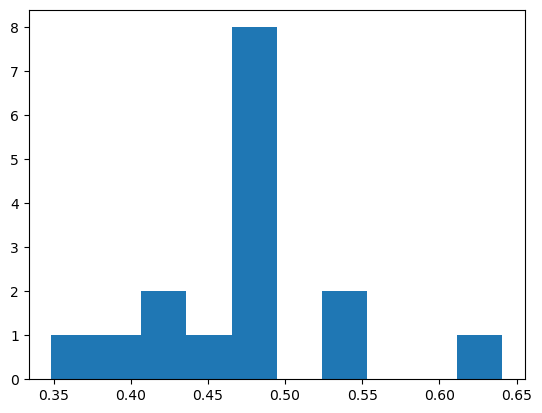

In [4]:
plt.hist(mice_data.proportion_of_time);

In [5]:
print('95% confidence interval for the mean proportion of time:', zconfint(mice_data))

95% confidence interval for the mean proportion of time: (array([0.44291783]), array([0.50765996]))


### Sign and signed rank tests

$H_0\colon$ median proportion of time spent in the room with the mirror is 0.5

$H_1\colon$ median proportion of time spent in the room with the mirror is not 0.5

In [6]:
print("Sign test:", sign_test(mice_data, mu0=0.5))
print("Signed rank test:", sc.stats.wilcoxon(mice_data.proportion_of_time - 0.5))

Sign test: (-5.0, 0.021270751953125)
Signed rank test: WilcoxonResult(statistic=35.0, pvalue=0.09344482421875)


### Permutation test

$H_0\colon$ mean proportion of time spent in the room with the mirror is 0.5

$H_1\colon$ mean proportion of time spent in the room with the mirror is not 0.5

Permutation test is not available in standard packages - let's implement it ourselves!

In [7]:
def permutation_t_stat_1s(sample, mean):
    t_stat = sum(sample - mean)
    return t_stat

def permutation_null_distr_1s(sample, mean, max_permutations = None):
    centered_sample = sample - mean
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [permutation_t_stat_1s(centered_sample * np.array(signs), 0) for signs in signs_array]
    return distr

def permutation_test_1s(sample, mean, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1s(sample, mean)
    
    null_distr = permutation_null_distr_1s(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

If the parameter max_permutations is not set, the function would use all the permutations (might be slow).

In [8]:
res = permutation_test_1s(mice_data.proportion_of_time, 0.5, return_distr=True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = -0.395378, p = 0.157776


Here's the null distribution of the permutation test statistic for our data; we don't have to look at it, but it might be a good idea - to check whether it's not too discrete:

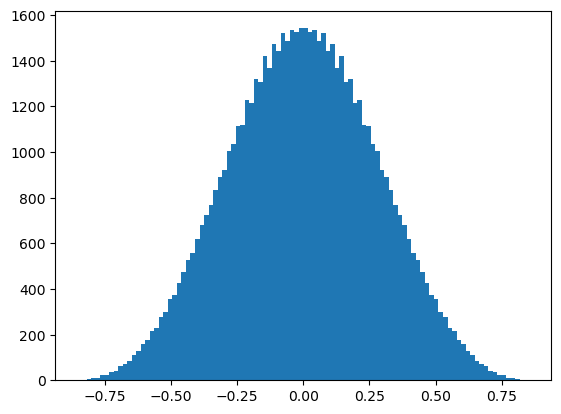

In [9]:
plt.hist(res['null_distr'], bins = 100);

## Two paired samples

### Data: cognitive behaviour therapy for anorexia
For 29 young girls with anorexia we have weight measurements before and after they went through cognitive behaviour therapy. 

Everett, as cited in Hand et al. (1994) A Handbook of Small Datasets. 

In [11]:
weight_data = pd.read_csv('../datasets/weight.txt', sep = '\t', header = 0)
weight_data.head()

,Before,After
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4
3,82.6,81.9
4,79.9,76.4


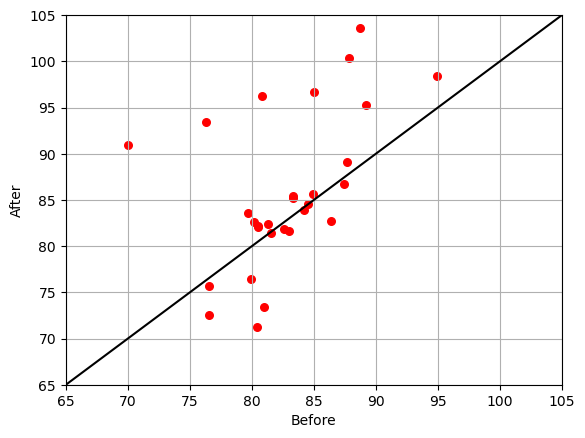

In [12]:
weight_data.plot.scatter('Before', 'After', c = 'r', s = 30)
plt.grid()
plt.plot(range(110), c = 'black')
plt.xlim((65, 105))
plt.ylim((65, 105));

### Sign and signed rank tests

$H_0\colon$ median weight change from before to after the treatment is 0.

$H_1\colon$ median weight change from before to after the treatment is not 0.

In [13]:
print("Sign test:", sign_test(weight_data.After - weight_data.Before))
print("Signed rank test:", sc.stats.wilcoxon(weight_data.After, weight_data.Before))

Sign test: (3.5, 0.26493089646101)
Signed rank test: WilcoxonResult(statistic=131.5, pvalue=0.06551516801118851)


### Permutation test

$H_0\colon$ mean weight change is 0.

$H_1\colon$ mean weight change is not 0.

We'll use functions defined above in the one sample section, and set max_permutations = 10000 for speed. 

In [14]:
res = permutation_test_1s(weight_data.After - weight_data.Before, 0., max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 87.200000, p = 0.035700


Null distribution of the permutation test statistic for our data:

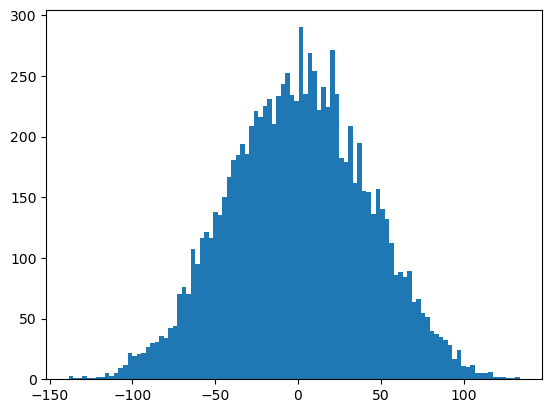

In [15]:
plt.hist(res['null_distr'], bins=100);

## Two independent samples

### Data:  real estate sales in Seattle
We have selling prices for Seattle real estate sales (in thousands of dollars), 50 records for 2001 and 50 for 2002. Did the average price change?

Hestberg, T., Monaghan, S., Moore, D.S., Clipson, A., Epstein, R. (2003) Bootstrap methods and permutation tests. 

In [18]:
seattle_data = pd.read_csv('../datasets/seattle.txt', sep = '\t', header = 0)
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [19]:
prices2001 = seattle_data[seattle_data['Year']  == 2001].Price
prices2002 = seattle_data[seattle_data['Year']  == 2002].Price

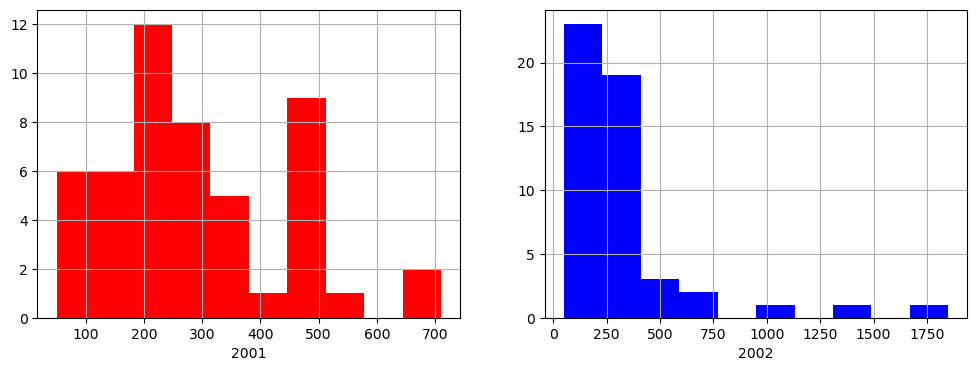

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(prices2001, color = 'r')
plt.xlabel('2001')

plt.subplot(1,2,2)
plt.grid()
plt.hist(prices2002, color = 'b')
plt.xlabel('2002');

### Mann-Whitney rank test

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [21]:
print("Mann-Whitney test:", sc.stats.mannwhitneyu(prices2001, prices2002))

Mann-Whitney test: MannwhitneyuResult(statistic=1295.5, pvalue=0.7563872675701748)


### Permutation test
$H_0\colon$ average prices are the same in 2001 and 2002.

$H_1\colon$ average prices are not the same in 2001 and 2002.

In [22]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [23]:
res = permutation_test_2s(prices2001, prices2002, max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = -40.330600, p = 0.440600


For two independent samples, it might be beneficial to look at permutation distribution. If groups are of different sizes and distributions in both of them are skewed, we should be careful when testing hypothesis against two-sided alternative: if permutation distribution is asymmetric, the power of the test could be very low. Null distribution of the permutation test statistic for our data:

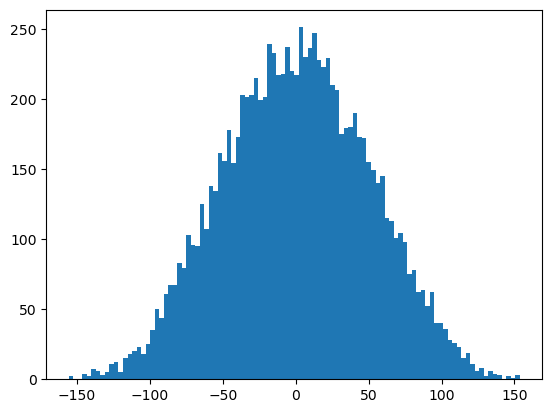

In [24]:
plt.hist(res['null_distr'], bins = 100);

Looks quite symmetric – we're safe.